In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time
from mpl_toolkits.mplot3d import Axes3D 
import scipy

In [2]:
import gymnasium
from gymnasium import spaces

In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp 

In [4]:
x0, y0, z0 = 9, 5, 5

### Finite Element Model

In [5]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
#     print(params)
    return ObjectView(params)

def mbb_beam(width=z0*3, height=z0*3, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [6]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [7]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [8]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [9]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [10]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [11]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [12]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [13]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

### RL model

In [14]:
class Model:
    def __init__(self, x):
        self.flag_ = True
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
   

In [15]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X) 
    plt.show() 

In [16]:
class CantileverEnv(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self,x1,y1):
        super().__init__()
        self.x0=x1
        self.y0=y1
        
        DIM =  self.x0 * self.y0
        N_DISCRETE_ACTIONS = self.x0 * self.y0
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = np.zeros(( self.x0, self.y0))
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        self.ext_reward=0

        
    def step(self, action):
        
        
        self.M.action_space_(action, self.x)        
        self.step_+=1
               
        done=False
                  
        if self.step_ > 4 * self.x0 * self.y0:
            done=True            
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
        
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.ext_reward, done, False, dict()

    def reset(self, seed=0):
                   
        self.x = np.zeros((self.x0, self.y0))

        self.reward=0
        self.needs_reset = False
        self.step_=0
        self.ext_reward=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        pass   

    def close(self):
        pass

In [17]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            
            
            
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
#             print(y)
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                
                mean_reward = np.mean(y[-100:])
                
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [18]:
def reconstruct_3d_structure(xy_plane, yz_plane, xz_plane):
    """
    Reconstructs a 3D structure from three 2D projections using extrusion and intersection.

    Parameters:
        xy_plane (ndarray): 2D binary array (X by Y) projection in XY plane.
        yz_plane (ndarray): 2D binary array (Y by Z) projection in YZ plane.
        xz_plane (ndarray): 2D binary array (X by Z) projection in XZ plane.

    Returns:
        volume (ndarray): 3D binary array (X by Y by Z) representing the reconstructed structure.
    """
    x_dim, y_dim = xy_plane.shape
    y_dim2, z_dim = yz_plane.shape
    x_dim2, z_dim2 = xz_plane.shape

    assert x_dim == x_dim2, "X dimensions mismatch between XY and XZ planes."
    assert y_dim == y_dim2, "Y dimensions mismatch between XY and YZ planes."
    assert z_dim == z_dim2, "Z dimensions mismatch between YZ and XZ planes."

    # Extrude XY along Z
    xy_extruded = np.repeat(xy_plane[:, :, np.newaxis], z_dim, axis=2)

    # Extrude YZ along X
    yz_extruded = np.repeat(yz_plane[np.newaxis, :, :], x_dim, axis=0)

    # Extrude XZ along Y
    xz_extruded = np.repeat(xz_plane[:, np.newaxis, :], y_dim, axis=1)

    # Intersect all three extrusions
    volume = xy_extruded & yz_extruded & xz_extruded

    return volume.astype(np.uint8)  # or bool, depending on your needs

In [19]:
def deconstruct(topology):
    grid = np.zeros((z0*3, z0*3), dtype=int)
    for i in range(9):
        row_offset = (i // 3) * z0
        col_offset = (i % 3) * z0
        grid[row_offset:row_offset+z0, col_offset:col_offset+z0] = topology[i]
    return grid

In [20]:
def count_islands_dfs(grid):
    """
    Calculates the number of islands in a 2D binary grid using Depth First Search (DFS).

    An island is formed by connected 1's (horizontally/vertically adjacent).
    
    Args:
        grid (list of lists): A 2D matrix with values 0 or 1.

    Returns:
        int: The total number of islands found.
    """
#     if not grid or not grid[0]:
#         return 0
    
    rows = len(grid)
    cols = len(grid[0])
    visited = set()
    island_count = 0

    def dfs(r, c):
        """Helper function to traverse and mark a single island as visited."""
        # Check boundary conditions and if the cell has already been visited or is water (0)
        if r < 0 or r >= rows or c < 0 or c >= cols or grid[r][c] == 0 or (r, c) in visited:
            return
        
        visited.add((r, c))
        
        # Recursively visit all adjacent cells (up, down, left, right)
        dfs(r + 1, c) # Down
        dfs(r - 1, c) # Up
        dfs(r, c + 1) # Right
        dfs(r, c - 1) # Left

    # Iterate through every cell in the grid
    for r in range(rows):
        for c in range(cols):
            # If we find land (1) that hasn't been visited yet, 
            # it means we've found the start of a new island.
            if grid[r][c] == 1 and (r, c) not in visited:
                island_count += 1
                # Start DFS from this point to mark all parts of this island
                dfs(r, c)
                
    return island_count

In [21]:
def calculate_smoothness_metric(binary_matrix):
    """
    Calculates a smoothness metric for a 2D binary matrix.
    Lower values indicate greater smoothness. A value of 0 means 
    the image is perfectly uniform or has only linear transitions.

    The metric is the sum of differences between a pixel and its
    right and bottom neighbors, effectively counting vertical and
    horizontal edges.

    Args:
        binary_matrix (list of lists or numpy array): A 2D matrix 
                                                     with values 0 or 1.

    Returns:
        int: The total count of horizontal and vertical transitions.
    """
    # Convert to a numpy array for efficient processing
    matrix = np.array(binary_matrix, dtype=int)
    h, w = matrix.shape
    
    # Calculate absolute differences for horizontal transitions
    # We slice the matrix to compare each element with its right neighbor
    horizontal_diffs = np.abs(matrix[:, :w-1] - matrix[:, 1:])
    
    # Calculate absolute differences for vertical transitions
    # We slice the matrix to compare each element with its bottom neighbor
    vertical_diffs = np.abs(matrix[:h-1, :] - matrix[1:, :])
    
    # The sum of these differences gives the total number of transitions (edges)
    total_transitions = np.sum(horizontal_diffs) + np.sum(vertical_diffs)
    
    return int(total_transitions)

In [22]:
class CrossRewardEnv(gymnasium.Env):
    def __init__(self):
        super().__init__()
        self.env1 = CantileverEnv(x0,y0)
        self.env2 = CantileverEnv(y0,z0)
        self.env3 = CantileverEnv(x0,z0)

        self.observation_space = spaces.Dict({
            'X_projection': self.env1.observation_space,
            'Y_projection': self.env2.observation_space,
            'Z_projection': self.env3.observation_space,
        })

        self.action_space = spaces.MultiDiscrete([x0*y0, y0*z0, x0*z0])
        self.step1_=0
        
    def reset(self,seed=0):
        obs1, info1 = self.env1.reset()
        obs2, info2 = self.env2.reset()
        obs3, info3 = self.env3.reset()
        self.step1_=0
        return {
            'X_projection': obs1,
            'Y_projection': obs2,
            'Z_projection': obs3
        }, {
            'X_projection': info1,
            'Y_projection': info2,
            'Z_projection': info3
        }

    def step(self, action):
        a1 = action[0]
        a2 = action[1]
        a3 = action[2]

        obs1_, r1, done1,_, info1 = self.env1.step(a1)
        obs2_, r2, done2,_, info2 = self.env2.step(a2)
        obs3_, r3, done3,_, info3 = self.env3.step(a3)
        obs1 = obs1_.reshape(x0,y0).astype(np.uint8)
        obs2 = obs2_.reshape(y0,z0).astype(np.uint8)
        obs3 = obs3_.reshape(x0,z0).astype(np.uint8)
        topology = reconstruct_3d_structure(obs1, obs2, obs3)
        obs1 = obs1_
        obs2 = obs2_
        obs3 = obs3_
        
        done11 = False
        s_u = np.sum(topology)

        if bool(s_u > 0.525*x0*y0*z0):
            done11 = True
            
        if done11:
            self.grid = deconstruct(topology)
            self.args = get_args(*mbb_beam(rd=-1))
            self.tmp, self.const = fast_stopt(self.args, self.grid.astype(float))
            self.step1_+=1

            reward = 1/self.tmp+1/calculate_smoothness_metric(self.grid.reshape(3*z0, 3*z0))
            
            if count_islands_dfs(self.grid)==1:
                reward*=10
                
            self.env1.ext_reward=reward
            self.env2.ext_reward=reward
            self.env3.ext_reward=reward
        else:
            reward=0
            self.env1.ext_reward=0
            self.env2.ext_reward=0
            self.env3.ext_reward=0
        
        done = done1 or done2 or done3 or bool(s_u > 0.9*x0*y0*z0)

       
        return {
            'X_projection': obs1,
            'Y_projection': obs2,
            'Z_projection': obs3
        }, reward, done, False, {
            'X_projection': info1,
            'Y_projection': info2,
            'Z_projection': info3,
        }

    def render(self, mode='human'):    
        draw(self.coord, self.elcon,'red')   

    def close(self):
        self.env1.close()
        self.env2.close()
        self.env3.close()

### Training 

In [23]:
ts = 3e6

In [24]:
# Create log dir
log_dir = "/tmp/gym7_v3alkkjdjsdkndf/"
os.makedirs(log_dir, exist_ok=True)

In [25]:
callback = SaveOnBestTrainingRewardCallback(check_freq=10_000, log_dir=log_dir)

In [26]:
env=CrossRewardEnv()
check_env(env)
env  = Monitor(env, log_dir)

In [27]:
start = time.time()
model = PPO("MultiInputPolicy", env).learn(total_timesteps=ts, callback=callback)
end = time.time()  

Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: 1.34
Saving new best model to /tmp/gym7_v3alkkjdjsdkndf/best_model.zip
Num timesteps: 20000
Best mean reward: 1.34 - Last mean reward per episode: 1.26
Num timesteps: 30000
Best mean reward: 1.34 - Last mean reward per episode: 1.20
Num timesteps: 40000
Best mean reward: 1.34 - Last mean reward per episode: 1.11
Num timesteps: 50000
Best mean reward: 1.34 - Last mean reward per episode: 1.24
Num timesteps: 60000
Best mean reward: 1.34 - Last mean reward per episode: 1.24
Num timesteps: 70000
Best mean reward: 1.34 - Last mean reward per episode: 0.89
Num timesteps: 80000
Best mean reward: 1.34 - Last mean reward per episode: 0.78
Num timesteps: 90000
Best mean reward: 1.34 - Last mean reward per episode: 0.82
Num timesteps: 100000
Best mean reward: 1.34 - Last mean reward per episode: 0.88
Num timesteps: 110000
Best mean reward: 1.34 - Last mean reward per episode: 0.68
Num timesteps: 120000
Best mean reward: 1

Num timesteps: 1010000
Best mean reward: 1.34 - Last mean reward per episode: 0.72
Num timesteps: 1020000
Best mean reward: 1.34 - Last mean reward per episode: 0.86
Num timesteps: 1030000
Best mean reward: 1.34 - Last mean reward per episode: 0.84
Num timesteps: 1040000
Best mean reward: 1.34 - Last mean reward per episode: 0.84
Num timesteps: 1050000
Best mean reward: 1.34 - Last mean reward per episode: 0.79
Num timesteps: 1060000
Best mean reward: 1.34 - Last mean reward per episode: 0.88
Num timesteps: 1070000
Best mean reward: 1.34 - Last mean reward per episode: 0.87
Num timesteps: 1080000
Best mean reward: 1.34 - Last mean reward per episode: 1.05
Num timesteps: 1090000
Best mean reward: 1.34 - Last mean reward per episode: 0.86
Num timesteps: 1100000
Best mean reward: 1.34 - Last mean reward per episode: 1.19
Num timesteps: 1110000
Best mean reward: 1.34 - Last mean reward per episode: 1.06
Num timesteps: 1120000
Best mean reward: 1.34 - Last mean reward per episode: 1.03
Num 

Num timesteps: 1950000
Best mean reward: 3.20 - Last mean reward per episode: 3.88
Saving new best model to /tmp/gym7_v3alkkjdjsdkndf/best_model.zip
Num timesteps: 1960000
Best mean reward: 3.88 - Last mean reward per episode: 2.82
Num timesteps: 1970000
Best mean reward: 3.88 - Last mean reward per episode: 2.75
Num timesteps: 1980000
Best mean reward: 3.88 - Last mean reward per episode: 3.79
Num timesteps: 1990000
Best mean reward: 3.88 - Last mean reward per episode: 3.73
Num timesteps: 2000000
Best mean reward: 3.88 - Last mean reward per episode: 4.80
Saving new best model to /tmp/gym7_v3alkkjdjsdkndf/best_model.zip
Num timesteps: 2010000
Best mean reward: 4.80 - Last mean reward per episode: 3.63
Num timesteps: 2020000
Best mean reward: 4.80 - Last mean reward per episode: 3.58
Num timesteps: 2030000
Best mean reward: 4.80 - Last mean reward per episode: 4.90
Saving new best model to /tmp/gym7_v3alkkjdjsdkndf/best_model.zip
Num timesteps: 2040000
Best mean reward: 4.90 - Last me

Num timesteps: 2790000
Best mean reward: 12.70 - Last mean reward per episode: 10.59
Num timesteps: 2800000
Best mean reward: 12.70 - Last mean reward per episode: 10.43
Num timesteps: 2810000
Best mean reward: 12.70 - Last mean reward per episode: 11.41
Num timesteps: 2820000
Best mean reward: 12.70 - Last mean reward per episode: 11.93
Num timesteps: 2830000
Best mean reward: 12.70 - Last mean reward per episode: 11.75
Num timesteps: 2840000
Best mean reward: 12.70 - Last mean reward per episode: 10.66
Num timesteps: 2850000
Best mean reward: 12.70 - Last mean reward per episode: 10.23
Num timesteps: 2860000
Best mean reward: 12.70 - Last mean reward per episode: 10.78
Num timesteps: 2870000
Best mean reward: 12.70 - Last mean reward per episode: 10.42
Num timesteps: 2880000
Best mean reward: 12.70 - Last mean reward per episode: 11.18
Num timesteps: 2890000
Best mean reward: 12.70 - Last mean reward per episode: 13.96
Saving new best model to /tmp/gym7_v3alkkjdjsdkndf/best_model.zip

In [28]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 63.26643676757813 min


### Inference

In [29]:
obs = env.reset()

In [30]:
obs = obs[0]

In [31]:
i=0
ans=[]
while i < 1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _, info = env.step(action)
    ans.append(obs)
    if dones:
        break
    i+=1

In [32]:
topology = reconstruct_3d_structure(ans[-1]['X_projection'].astype(np.uint8).reshape(x0,y0), 
                                    ans[-1]['Y_projection'].astype(np.uint8).reshape(y0,z0),
                                    ans[-1]['Z_projection'].astype(np.uint8).reshape(x0,z0))
grid = deconstruct(topology)


Final Cantilever beam design:


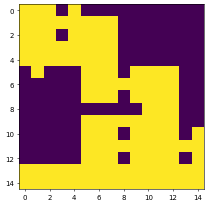

In [33]:
draw(grid)

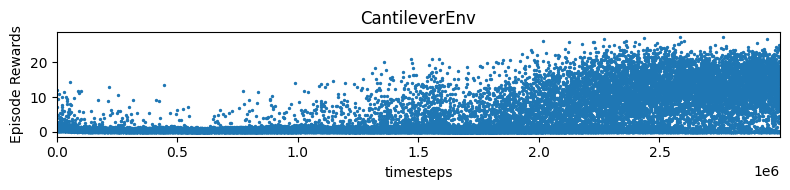

In [34]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [35]:
obs = env.reset()

In [36]:
obs = obs[0]

In [37]:
model_best = PPO.load(log_dir + "best_model.zip", env = env)

In [38]:
i=0
ans=[]
while i<1000:
    action, _states = model_best.predict(obs)
    obs, rewards, dones, _ , info = env.step(action)
    ans.append(obs)
    if dones:
        break
    
    i+=1

In [39]:
topology = reconstruct_3d_structure(ans[-1]['X_projection'].astype(np.uint8).reshape(x0,y0), 
                                    ans[-1]['Y_projection'].astype(np.uint8).reshape(y0,z0),
                                    ans[-1]['Z_projection'].astype(np.uint8).reshape(x0,z0))
grid = deconstruct(topology)


Final Cantilever beam design:


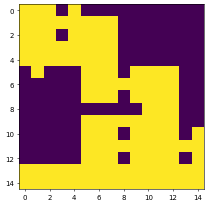

In [40]:
draw(grid)

In [41]:
args = get_args(*mbb_beam(rd=-1))
tmp, const = fast_stopt(args, grid.astype(float))

In [42]:
tmp

32.92394004094896

In [43]:
const

0.5555555555555556

In [44]:
grid

array([[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])